# Rascunho

In [47]:
import numpy as np
import pystan as ps
import sympy as sp

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
sns.set()

from scipy.special import expit

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

In [97]:
model_code = """
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real alpha, 
    int[,] W_sparse, vector D_sparse, vector lambda, int n, int W_n) {
      row_vector[n] phit_D; // phi' * D
      row_vector[n] phit_W; // phi' * W
      vector[n] ldet_terms;
    
      phit_D = (phi .* D_sparse)';
      phit_W = rep_row_vector(0, n);
      for (i in 1:W_n) {
        phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
        phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
      }
    
      for (i in 1:n) ldet_terms[i] = log1m(alpha * lambda[i]);
      return 0.5 * (sum(ldet_terms) - (phit_D * phi - alpha * (phit_W * phi)));
  }
  real gumbel_type2_lpdf(real tau, real lambda){
    return -(3.0/2.0 * log(tau) + lambda / sqrt(tau)); 
  }
}
data {
  int<lower = 1> n;
  int<lower = 1> p;
  matrix[n, p] X;
  int<lower = 0> y[n];
  vector[n] log_offset;
  matrix<lower = 0, upper = 1>[n, n] W; // adjacency matrix
  int W_n;                // number of adjacent region pairs
  real<lower = 0> alpha_tau;
  real<lower = 0> beta_tau;
  real<lower = 0> lambda_tau; 
  
  int<lower = 0, upper = 1> gumbel_prior;
  int<lower = 0, upper = 1> poisson_model;
}
transformed data {
  int W_sparse[W_n, 2];   // adjacency pairs
  vector[n] D_sparse;     // diagonal of D (number of neigbors for each site)
  vector[n] lambda;       // eigenvalues of invsqrtD * W * invsqrtD
  
  { // generate sparse representation for W
  int counter;
  counter = 1;
  // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1:(n - 1)) {
      for (j in (i + 1):n) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1:n) D_sparse[i] = sum(W[i]);
  {
    vector[n] invsqrtD;  
    for (i in 1:n) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}
parameters {
  vector[p] beta;
  vector[n] phi;
  real<lower = 0> tau;
  real<lower = 0, upper = 1> alpha;
}
model {
  if (gumbel_prior == 1) {
     tau ~ gumbel_type2(lambda_tau);
  } else {
     tau ~ gamma(alpha_tau, beta_tau);
  }
  
  phi ~ sparse_car(alpha, W_sparse, D_sparse, lambda, n, W_n);
  beta ~ normal(0, 1);
  
  if (poisson_model == 1){
      y ~ poisson_log(X * beta + (1/sqrt(tau)) * phi + log_offset);
  } else {
      y ~ bernoulli_logit(X * beta + (1/sqrt(tau)) * phi + log_offset);
  }  
}
"""

In [98]:
model = ps.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb81ab853bb44598159a83ed5c57fc29 NOW.


In [119]:
n = 100
p = 4
X = np.random.multivariate_normal(mean = np.zeros(p), 
                                  cov = np.eye(p), 
                                  size = n)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
beta = np.random.multivariate_normal(mean = np.zeros(p), 
                                     cov = np.eye(p))
X[:,0] = 1

log_offset = np.zeros(n)

W = np.zeros((n,n), dtype = np.int64)
prob = 0.1
for i in range(n-1):
    for j in range(i+1, n): 
        if np.random.random() < prob: 
            W[i,j] = 1
            W[j,i] = 1
    if sum(W[i,:]) == 0:
        j = np.random.choice([k for k in range(n) if k != i])
        W[i,j] = 1
        W[j,i] = 1
        
W_n = W.sum() // 2

rho = 0.5
tau = 1
D = np.diag(W.sum(axis = 1))
phi = np.random.multivariate_normal(mean = np.zeros(n), 
                                    cov = (1/tau) * np.linalg.inv(D - rho * W))

y = np.random.binomial(n = 1, p = expit(X @ beta + phi + log_offset))
#y = np.random.poisson(np.exp(expit(X @ beta + phi + log_offset)))

data = {
    "n": n,
    "p": p,
    "X": X,
    "y": y,
    "log_offset": log_offset,
    "W": W,
    "W_n": W_n,
    "alpha_tau": 0.01,
    "beta_tau": 0.01,
    "lambda_tau": np.log(10),
    "gumbel_prior": 1,
    "poisson_model": 0
}

In [124]:
fit = model.sampling(data=data, control = {'adapt_delta': 0.95}, iter = 4000)
summary = az.summary(fit)

In [125]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.221,0.248,-0.256,0.683,0.002,0.002,11642.0,6119.0,11649.0,6096.0,1.0
beta[1],-0.848,0.274,-1.385,-0.366,0.003,0.002,9335.0,8092.0,9452.0,5784.0,1.0
beta[2],0.285,0.254,-0.197,0.749,0.002,0.002,10362.0,6035.0,10460.0,5963.0,1.0
beta[3],1.559,0.329,0.919,2.145,0.003,0.002,9963.0,8851.0,10388.0,6080.0,1.0
phi[0],0.017,0.295,-0.533,0.573,0.003,0.004,9366.0,3556.0,9367.0,6034.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
phi[97],0.023,0.418,-0.739,0.813,0.004,0.005,10631.0,3747.0,10635.0,5842.0,1.0
phi[98],0.018,0.325,-0.611,0.617,0.003,0.004,9294.0,3021.0,9288.0,5638.0,1.0
phi[99],0.017,0.285,-0.527,0.539,0.003,0.003,8951.0,3448.0,8947.0,5460.0,1.0
tau,117546.898,4315434.396,0.033,1500.633,53882.069,38102.109,6414.0,6414.0,4745.0,3485.0,1.0


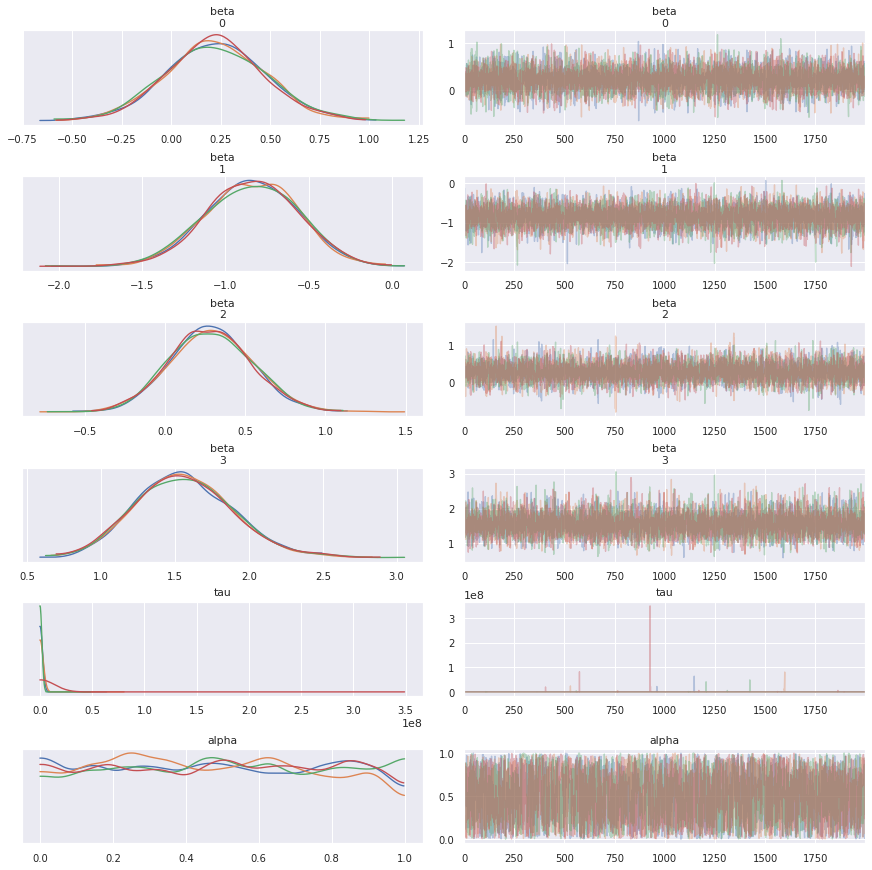

In [126]:
az.plot_trace(fit, var_names=('beta', 'tau', 'alpha'))
plt.show()

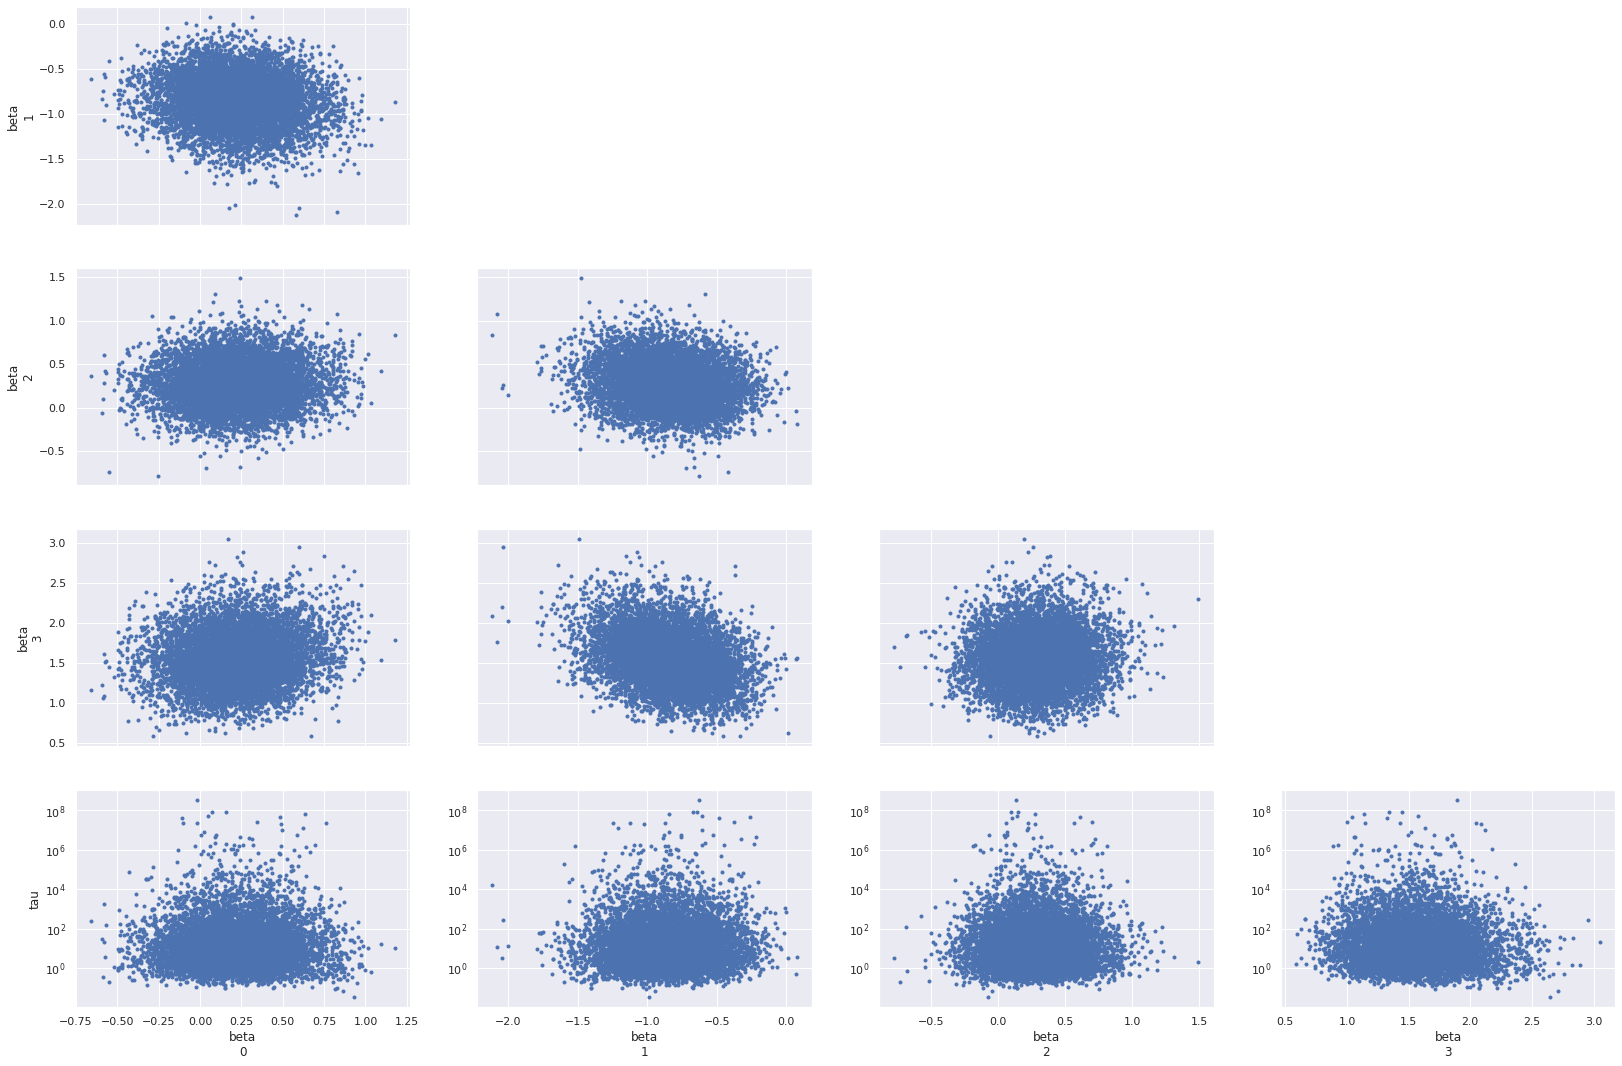

In [127]:
inference_data = az.convert_to_inference_data(fit)
ax = az.plot_pair(inference_data, var_names=('beta', 'tau'), divergences=True, group = 'posterior')
for i in range(4):
    ax[3,i].set_yscale('log')
plt.show()